## Import library

In [1]:
import sys
sys.path.insert(
    1,
    '/home/dtd/Documents/interpretable_machine_learning/Source Code/my_work/lib'
)
sys.path.insert(
    1,
    '/home/dtd/Documents/interpretable_machine_learning/Causal Inference/CEA')

import data_load
import numpy as np
import pandas as pd
import logging
import dowhy.datasets
import dowhy
import propensity_score_estimator as pse
import incremental_ps_score_estimator as ipse
import math
import timeit
import evaluation as evl
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt

from dowhy import CausalModel
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import sem
from dowhy import CausalModel
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from math import sqrt
from econml.dml import LinearDMLCateEstimator
from sklearn.linear_model import LassoCV
from econml.inference import BootstrapInference
from econml.dml import SparseLinearDMLCateEstimator
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from mlens.ensemble import SuperLearner
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
[MLENS] backend: threading


## Load data 

In [58]:
# Import the sample AB data
file_url = "https://msalicedatapublic.blob.core.windows.net/datasets/RecommendationAB/ab_sample.csv"   
ab_data = pd.read_csv(file_url)

In [59]:
ab_data.head()

,days_visited_exp_pre,days_visited_free_pre,days_visited_fs_pre,days_visited_hs_pre,days_visited_rs_pre,days_visited_vrs_pre,locale_en_US,revenue_pre,os_type_osx,os_type_windows,easier_signup,became_member,days_visited_post
0,1,9,7,25,6,3,1,0.01,0,1,0,0,1
1,10,25,27,10,27,27,0,2.26,0,0,0,0,15
2,18,14,8,4,5,2,1,0.03,0,1,0,0,17
3,17,0,23,2,3,1,1,418.77,0,1,0,0,6
4,24,9,22,2,3,18,1,1.54,0,0,0,0,12


In [60]:
ab_data.became_member.value_counts()

0    64780
1    35220
Name: became_member, dtype: int64

In [61]:
ab_data.columns

Index(['days_visited_exp_pre', 'days_visited_free_pre', 'days_visited_fs_pre',
       'days_visited_hs_pre', 'days_visited_rs_pre', 'days_visited_vrs_pre',
       'locale_en_US', 'revenue_pre', 'os_type_osx', 'os_type_windows',
       'easier_signup', 'became_member', 'days_visited_post'],
      dtype='object')

In [62]:
# Define estimator inputs
Z = ab_data['easier_signup'] # nudge, or instrument
T = ab_data['became_member'] # intervention, or treatment
Y = ab_data['days_visited_post'] # outcome of interest
X_data = ab_data.drop(columns=['easier_signup', 'became_member', 'days_visited_post']) # features

col = ['days_visited_exp_pre', 'days_visited_free_pre', 'days_visited_fs_pre',
       'days_visited_hs_pre', 'days_visited_rs_pre', 'days_visited_vrs_pre',
       'locale_en_US', 'revenue_pre', 'os_type_osx', 'os_type_windows',
       'easier_signup', 'became_member', 'days_visited_post']

cov = ['days_visited_exp_pre', 'days_visited_free_pre', 'days_visited_fs_pre',
       'days_visited_hs_pre', 'days_visited_rs_pre', 'days_visited_vrs_pre',
       'locale_en_US', 'revenue_pre', 'os_type_osx', 'os_type_windows',
       'easier_signup']

features = ['days_visited_exp_pre', 'days_visited_free_pre', 'days_visited_fs_pre',
       'days_visited_hs_pre', 'days_visited_rs_pre', 'days_visited_vrs_pre',
       'locale_en_US', 'revenue_pre', 'os_type_osx', 'os_type_windows',
            'became_member', 'days_visited_post']

treatment = 'became_member' # intervention, or treatment
outcome = 'days_visited_post' # outcome of interest




In [63]:
# Define underlying treatment effect function 
TE_fn = lambda X: (0.2 + 0.3 * X['days_visited_free_pre'] - 0.2 * X['days_visited_hs_pre'] + X['os_type_osx']).values
true_TE = TE_fn(ab_data[cov])

In [64]:
true_effect = np.mean(true_TE)

In [65]:

### become member => revenue_pre
model_t = LogisticRegression()
model_t.fit(ab_data[cov], ab_data[treatment])

## Fit outcome
model_y = GradientBoostingRegressor(random_state=0, n_estimators = 5000)
model_y.fit(ab_data[features], ab_data[outcome])

delta = 0.47
influence = ipse.influence_function(ab_data, treatment, cov, outcome, delta, model_y, model_t)
means_incre, stds_incre = np.mean(influence, axis=0), sem(influence, axis=0)

print("Estimation effect {:.2f}".format(means_incre))
print("True effect {:.2f}".format(true_effect))

/home/dtd/.conda/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Estimation effect 1.92
True effect 1.94


In [66]:
ab_data['predicted_y'] = [1 if x >= 0.5 else 0 for x in ab_data['q1']]
print(ab_data.predicted_y.value_counts())
print(ab_data.became_member.value_counts())

0    70872
1    29128
Name: predicted_y, dtype: int64
0    64780
1    35220
Name: became_member, dtype: int64


## Optimzation with individual delta and true_effect

In [67]:
true_effect = 1.9633999999999998*1.1

def incre_ps(delta, data):
    q1 = (delta * data['p1']) / (delta * data['p1'] + data['p0'])
    a0 = (1-q1)*data['w0']*(data['cf0'] - data[outcome])
    a1 = q1*data['w1']*(data['cf1'] - data[outcome])    
    influence = a1 - a0
    return tf.reduce_mean(influence)

def optimization(data, threhold):
    delta = tf.Variable(3., trainable = True)
    losses = []
    delta_seq = []
    estimation_effects = []
    for i in tqdm(range(10000)):
        with tf.GradientTape() as tape:
            influence = incre_ps(delta, data)
            loss = tf.math.abs(true_effect - influence)
            d_delta = tape.gradient(loss, delta)
            opt = tf.keras.optimizers.Adam(learning_rate=0.001)
            opt.apply_gradients(zip([d_delta], [delta]))
            delta_seq.append(delta.numpy())
            losses.append(loss.numpy())
            estimation_effects.append(influence.numpy())
            if loss <= threhold:
                print("MAE achieve {}. Cancelling the training progress".format(threhold))
                break
            
            if i % 1000 == 0:
                print("Step {} with loss {:.2f} and delta {:.2f}".format(i, loss.numpy(), delta.numpy()))
            
    
    return delta, delta_seq, losses, estimation_effects

In [68]:
threhold = 0.00
delta, delta_seq, losses,estimation_effects = optimization(ab_data, threhold)
optimal_value = incre_ps(delta, ab_data)
optimal_value = np.round(optimal_value.numpy(),2)
delta = np.round(delta.numpy(),2)

print("Optimization value {:.2f} with delta {:.2f}".format(np.mean(optimal_value), delta))
print("True effect {:.2f}".format(true_effect))
mae = np.round(abs(true_effect - optimal_value),2)
print("MAE: {:.2f}".format(mae))

  0%|          | 0/10000 [00:00<?, ?it/s]

Step 0 with loss 3.46 and delta 3.00


 10%|█         | 1013/10000 [00:11<01:34, 95.48it/s]

Step 1000 with loss 2.85 and delta 2.00


 20%|██        | 2011/10000 [00:22<01:28, 90.46it/s]

Step 2000 with loss 1.63 and delta 1.00


 25%|██▌       | 2533/10000 [00:28<01:22, 90.24it/s]

MAE achieve 0.03. Cancelling the training progress
Optimization value 1.94 with delta 0.47
True effect 1.96
MAE: 0.02


In [69]:
min(delta_seq), max(delta_seq)

(0.46603262, 2.999)

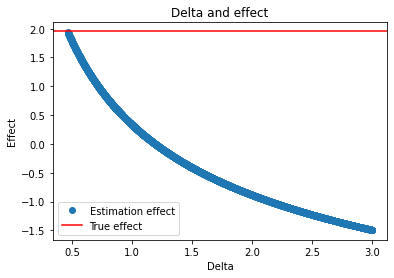

In [70]:
plt.plot(delta_seq, estimation_effects, 'o', label='Estimation effect')
plt.axhline(y=true_effect, color='r', linestyle='-', label='True effect')
plt.title('Delta and effect')
plt.xlabel('Delta')
plt.ylabel('Effect')
plt.legend()
plt.show()


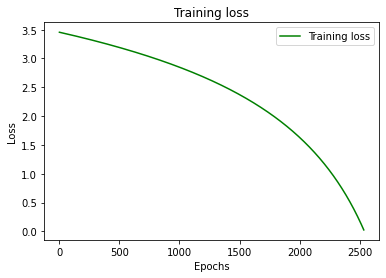

In [71]:
epochs = range(1,len(losses)+1)
plt.plot(epochs, losses, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

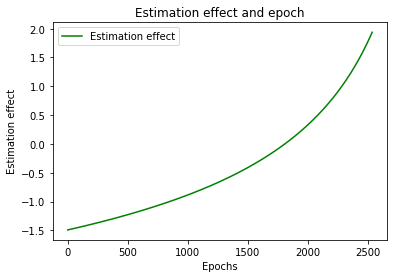

In [72]:
epochs = range(1,len(losses)+1)
plt.plot(epochs, estimation_effects, 'g', label='Estimation effect')
plt.title('Estimation effect and epoch')
plt.xlabel('Epochs')
plt.ylabel('Estimation effect')
plt.legend()
plt.show()

## Optimization with list of delta

In [74]:
delta_seq = np.linspace(start = 0, stop = 2, num = len(ab_data))

In [84]:
true_TE = TE_fn(ab_data[cov])
true_TE = tf.convert_to_tensor(true_TE, np.float32)

def incre_ps(delta, data):
    q1 = (delta * data['p1']) / (delta * data['p1'] + data['p0'])
    #q1 = tf.math.abs(q1)
    a0 = (1-q1)*data['w0']*(data['cf0'] - data[outcome])
    a1 = q1*data['w1']*(data['cf1'] - data[outcome])    
    influence = a1 - a0
    return influence
    #return tf.reduce_mean(influence)

def optimization(data, threhold):
    delta_seq = tf.Variable(tf.random.normal([len(data), ], mean=0.0, stddev=1.0), name="delta")
    losses = []
    estimation_effects = []
    for i in tqdm(range(10000)):
        with tf.GradientTape() as tape:
            influence = incre_ps(delta_seq, data)
            loss = tf.losses.mean_squared_error(true_TE, influence)
            #loss = abs(influence - true_effect)
            d_delta = tape.gradient(loss, delta_seq)
            delta_seq.assign_sub(d_delta * 0.001)    
            losses.append(loss.numpy())
            estimation_effects.append(influence.numpy())
            if loss <= threhold:
                print("MAE achieve {}. Cancelling the training progress".format(threhold))
                break
            
            if i % 1000 == 0:
                print("Step {} with loss {:.2f}".format(i, loss.numpy()))
                print(delta_seq)
                print("*"*100)
                
    return delta_seq, losses, estimation_effects

In [85]:
threhold = 0.03
delta_seq, losses, estimation_effects = optimization(ab_data, threhold)
optimal_value = incre_ps(delta, ab_data)


  0%|          | 12/10000 [00:00<01:29, 112.14it/s]

Step 0 with loss 498814.91
<tf.Variable 'delta:0' shape=(100000,) dtype=float32, numpy=
array([-1.6386117 , -0.8139406 , -0.1693522 , ...,  1.5649226 ,
        0.77729434, -0.86691576], dtype=float32)>
****************************************************************************************************


 10%|█         | 1015/10000 [00:08<01:16, 117.82it/s]

Step 1000 with loss 2180.65
<tf.Variable 'delta:0' shape=(100000,) dtype=float32, numpy=
array([-1.6386117 , -0.8140002 , -0.16941181, ...,  1.5649226 ,
        0.77741355, -0.86710894], dtype=float32)>
****************************************************************************************************


 20%|██        | 2016/10000 [00:17<01:05, 122.17it/s]

Step 2000 with loss 2107.86
<tf.Variable 'delta:0' shape=(100000,) dtype=float32, numpy=
array([-1.6386117 , -0.8140598 , -0.16947141, ...,  1.5649226 ,
        0.77753276, -0.86728776], dtype=float32)>
****************************************************************************************************


 30%|███       | 3019/10000 [00:25<00:57, 120.43it/s]

Step 3000 with loss 2057.93
<tf.Variable 'delta:0' shape=(100000,) dtype=float32, numpy=
array([-1.6386117 , -0.8141194 , -0.16953102, ...,  1.5649226 ,
        0.77765197, -0.86746657], dtype=float32)>
****************************************************************************************************


 40%|████      | 4017/10000 [00:34<00:48, 122.36it/s]

Step 4000 with loss 2017.75
<tf.Variable 'delta:0' shape=(100000,) dtype=float32, numpy=
array([-1.6386117 , -0.814179  , -0.16959062, ...,  1.5649226 ,
        0.7777712 , -0.8676454 ], dtype=float32)>
****************************************************************************************************


 50%|█████     | 5020/10000 [00:42<00:47, 104.67it/s]

Step 5000 with loss 1983.77
<tf.Variable 'delta:0' shape=(100000,) dtype=float32, numpy=
array([-1.6386117 , -0.8142386 , -0.16965023, ...,  1.5649226 ,
        0.7778904 , -0.8678242 ], dtype=float32)>
****************************************************************************************************


 60%|██████    | 6017/10000 [00:51<00:36, 109.01it/s]

Step 6000 with loss 1952.42
<tf.Variable 'delta:0' shape=(100000,) dtype=float32, numpy=
array([-1.6386117 , -0.8142982 , -0.16970983, ...,  1.5649226 ,
        0.7780096 , -0.868003  ], dtype=float32)>
****************************************************************************************************


 70%|███████   | 7025/10000 [01:00<00:24, 122.76it/s]

Step 7000 with loss 1924.40
<tf.Variable 'delta:0' shape=(100000,) dtype=float32, numpy=
array([-1.6386117 , -0.8143578 , -0.16976944, ...,  1.5649226 ,
        0.7781288 , -0.8681818 ], dtype=float32)>
****************************************************************************************************


 80%|████████  | 8022/10000 [01:09<00:17, 112.46it/s]

Step 8000 with loss 1898.79
<tf.Variable 'delta:0' shape=(100000,) dtype=float32, numpy=
array([-1.6386117 , -0.8144174 , -0.16982904, ...,  1.5649226 ,
        0.778248  , -0.86836064], dtype=float32)>
****************************************************************************************************


 90%|█████████ | 9015/10000 [01:17<00:08, 116.01it/s]

Step 9000 with loss 1874.22
<tf.Variable 'delta:0' shape=(100000,) dtype=float32, numpy=
array([-1.6386117 , -0.814477  , -0.16988865, ...,  1.5649226 ,
        0.7783672 , -0.86853945], dtype=float32)>
****************************************************************************************************


100%|██████████| 10000/10000 [01:26<00:00, 115.92it/s]


In [86]:
delta_seq

<tf.Variable 'delta:0' shape=(100000,) dtype=float32, numpy=
array([-1.6386117 , -0.8145366 , -0.16994819, ...,  1.5649226 ,
        0.7784863 , -0.8687181 ], dtype=float32)>